In [1]:
import pandas as pd
import numpy as np

**Ler o arquivo com o enconding certo**

In [2]:
file_path = 'waitlist_kidney_brazil.csv'
data = pd.read_csv(file_path, encoding='ISO-8859-1')

In [3]:
from sklearn.preprocessing import LabelEncoder

# criar uma copia do dataframe para manipulacoes
df = data.copy()

# codificar variaveis categoricas
label_encoders = {}
categorical_columns = ['sex', 'race', 'Blood_type', 'underline_disease', 'age_cat']

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# verificar se ha valores ausentes nas colunas relevantes e preenche-los se necessario
missing_values = df.isnull().sum()

# preenchendo valores ausentes na coluna 'time_on_Dialysis' com a media, ja que e uma variavel crucial
df['time_on_Dialysis'].fillna(df['time_on_Dialysis'].mean(), inplace=True)

# mostrar a nova estrutura do dataframe
df.head(), missing_values[missing_values > 0]


C:\Users\Vemado\AppData\Local\Temp\ipykernel_20572\4124864206.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['time_on_Dialysis'].fillna(df['time_on_Dialysis'].mean(), inplace=True)


(   Id        date  age_at_list_registration  age_cat  time_on_Dialysis  race  \
 0   4  2017-06-29                        67        1               1.0     1   
 1   5  2008-11-03                        58        0               4.0     1   
 2   6  2010-07-13                        51        0               2.0     1   
 3   7  2011-10-03                        52        0              17.0     1   
 4   8  2006-07-05                        67        1              68.0     3   
 
    sex  underline_disease  diabetes  Blood_type  ...  Time_death   Transplant  \
 0    1                  3         1           0  ...          13          Não   
 1    1                  0         0           0  ...          69  Óbito Lista   
 2    1                  2         1           3  ...          98          Não   
 3    1                  0         0           3  ...          83          Não   
 4    1                  2         1           0  ...           6  Óbito Lista   
 
    Transplant_Y_N

**Modelo lasso para identificar as com maior correlacao**

In [4]:
from datetime import datetime, timedelta

In [5]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# selecionar variaveis que parecem ser relevantes 
features = ['Time_Tx','age_at_list_registration', 'age_cat', 'time_on_Dialysis', 'race', 'sex', 'diabetes', 'Blood_type']
target = 'time'  # tempo de espera na fila como variável alvo

# preparando dados para o modelo
X = df[features]
y = df[target]

# dividir dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# escalar os dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ajustar o modelo Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train_scaled, y_train)

# exibir os coeficientes do modelo
feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': lasso.coef_})
feature_importance


,Feature,Coefficient
0,Time_Tx,926.811726
1,age_at_list_registration,-0.370583
2,age_cat,-6.749953
3,time_on_Dialysis,-4.169675
4,race,-0.000000
5,sex,-0.038805
6,diabetes,-0.962864
7,Blood_type,1.015086


In [6]:
# preparando dados para o modelo com todas as colunas numericas disponiveis
all_features = df.select_dtypes(include=[np.number]).columns.tolist()
all_features.remove('time')  # removendo a variavel alvo dos preditores
# all_features.remove('Time_Tx') 
X_all = df[all_features]
y_all = df['time']

# dividir dados em conjuntos de treino e teste para todas as colunas
X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.3, random_state=0)

# escalar os dados para todas as colunas
scaler_all = StandardScaler()
X_train_all_scaled = scaler_all.fit_transform(X_train_all)
X_test_all_scaled = scaler_all.transform(X_test_all)

# ajustar o modelo Lasso com todas as colunas
lasso_all = Lasso(alpha=0.1)
# preenchendo valores ausentes
x_all_transformada = X_all.fillna(X_all.mean())

# escalar os dados preenchidos
x_all_transformada_treino = scaler_all.fit_transform(x_all_transformada)

# ajustar o modelo Lasso 
lasso_all.fit(x_all_transformada_treino, y_all)

# exibir os coeficientes para ver a importancia das colunas
feature_importance_all_filled = pd.DataFrame({'Feature': all_features, 'Coefficient': lasso_all.coef_})
important_features = feature_importance_all_filled[feature_importance_all_filled['Coefficient'] != 0].sort_values(by='Coefficient', key=abs, ascending=False)
important_features


,Feature,Coefficient
31,Time_Tx,911.787700
29,Time_death,19.045280
30,X36MthsTx,-18.157001
21,calculated_frequency_DR.f,-7.028829
20,calculated_frequency_DR.f2,6.354734
2,age_cat,-5.174321
27,calculated_frequency_A.f,-4.184418
26,calculated_frequency_A.f2,3.808732
19,calculated_frequency_DR.f1,3.378271
9,number_transfusion,-3.190059


In [7]:
colunas_categoricas = [col for col in df.columns if df[col].dtype == 'object' and col not in ['date', 'event']]
colunas_categoricas

['gestation',
 'prior_transplant',
 'subregion',
 'cPRA_cat',
 'DR_00',
 'B_00',
 'A_00',
 'chagas',
 'anti.HBc',
 'anti.HCV',
 'agHBs',
 'patient_still_on_list',
 'death',
 'Transplant',
 'Transplant_Y_N',
 'priorization',
 'removed_list',
 'razon_removed']

**Preparando os dados**

In [8]:
colunas_categoricas = ['gestation', 'prior_transplant', 'subregion', 'cPRA_cat', 'DR_00', 'B_00', 'A_00', 'chagas', 'anti.HBc', 'anti.HCV', 'agHBs', 'patient_still_on_list', 'death', 'Transplant', 'Transplant_Y_N', 'priorization', 'removed_list', 'razon_removed']

df_dummies = pd.get_dummies(df[colunas_categoricas], drop_first=True)
df_dummies.head()

,gestation_Sim,prior_transplant_Sim,subregion_HCFMUSP,subregion_UNICAMP,subregion_UNIFESP,cPRA_cat_Entre_50_80,cPRA_cat_Maior_80,cPRA_cat_Zero,DR_00_homozigoto,B_00_homozigoto,...,removed_list_Sim,razon_removed_Função renal recuperada,razon_removed_Não quer ser transplantado,razon_removed_Removido (inscrição duplicada),razon_removed_Removido (suspenso > 365 dias),razon_removed_Removido administrativo,razon_removed_Removido pela equipe,razon_removed_Removido sem condições clínicas,razon_removed_Transferido de Equipe,razon_removed_Transferido para outro Estado
0,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,True,True,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
3,False,True,False,False,True,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
4,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


**Modelo Logistico + medidas de acuracia**

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# selecionar apenas as features com maior coefieciente
selected_features = [ 'Time_Tx','Time_death', 'X36MthsTx', 'calculated_frequency_DR.f', 'calculated_frequency_DR.f2', 'age_cat']

x_numericas = x_all_transformada[selected_features]


# get dummies para colunas categoricas
x_colunas = pd.concat([x_numericas, df_dummies], axis=1)
x_colunas = pd.concat([x_colunas, y_all], axis=1)

x_colunas= x_colunas[x_colunas['removed_list_Sim']==True]
y_all= x_colunas['time']
y_selected = (y_all > y_all.median()).astype(int)  # variavel binaria baseada na mediana do tempo de espera
x_colunas = x_colunas.drop('time', axis=1)



In [10]:
x_colunas

,Time_Tx,Time_death,X36MthsTx,calculated_frequency_DR.f,calculated_frequency_DR.f2,age_cat,gestation_Sim,prior_transplant_Sim,subregion_HCFMUSP,subregion_UNICAMP,...,removed_list_Sim,razon_removed_Função renal recuperada,razon_removed_Não quer ser transplantado,razon_removed_Removido (inscrição duplicada),razon_removed_Removido (suspenso > 365 dias),razon_removed_Removido administrativo,razon_removed_Removido pela equipe,razon_removed_Removido sem condições clínicas,razon_removed_Transferido de Equipe,razon_removed_Transferido para outro Estado
2,12.17,98,0,3.99,0.21,0,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
3,12.17,83,0,3.99,0.21,0,False,True,False,False,...,True,False,False,False,True,False,False,False,False,False
5,35.87,48,0,0.84,0.07,0,False,False,False,True,...,True,False,False,False,True,False,False,False,False,False
7,89.10,196,0,0.72,0.04,0,False,False,False,False,...,True,False,False,False,True,False,False,False,False,False
16,44.50,204,0,2.76,0.12,0,False,False,False,True,...,True,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48138,12.17,76,0,5.06,0.23,0,True,False,True,False,...,True,False,False,False,True,False,False,False,False,False
48141,12.17,108,0,3.00,0.25,0,True,False,False,True,...,True,False,False,False,True,False,False,False,False,False
48143,35.23,102,0,0.00,0.00,0,True,False,False,False,...,True,False,False,False,True,False,False,False,False,False
48144,44.70,130,0,4.75,0.25,1,False,False,False,False,...,True,False,False,False,False,False,False,True,False,False


In [11]:
# treino e teste
X_train_col, X_test_col, y_train_sel, y_test_sel = train_test_split(x_colunas, y_selected, test_size=0.3, random_state=0)

# escalar os dados
X_train_col_scaled = scaler.fit_transform(X_train_col)
X_test_col_scaled = scaler.transform(X_test_col)

#modelo com todas as variaveis
log_reg_enh = LogisticRegression(max_iter=1000)  
log_reg_enh.fit(X_train_col_scaled, y_train_sel)


y_pred_enh = log_reg_enh.predict(X_test_col_scaled)

# metricas de desempenho 
accuracy_enh = accuracy_score(y_test_sel, y_pred_enh)
precision_sel = precision_score(y_test_sel, y_pred_enh)
recall_enh = recall_score(y_test_sel, y_pred_enh)
f1_enh = f1_score(y_test_sel, y_pred_enh)

accuracy_enh, precision_sel, recall_enh, f1_enh

(0.9827849204619743, 0.9763676148796498, 0.9889184397163121, 0.982602950891874)

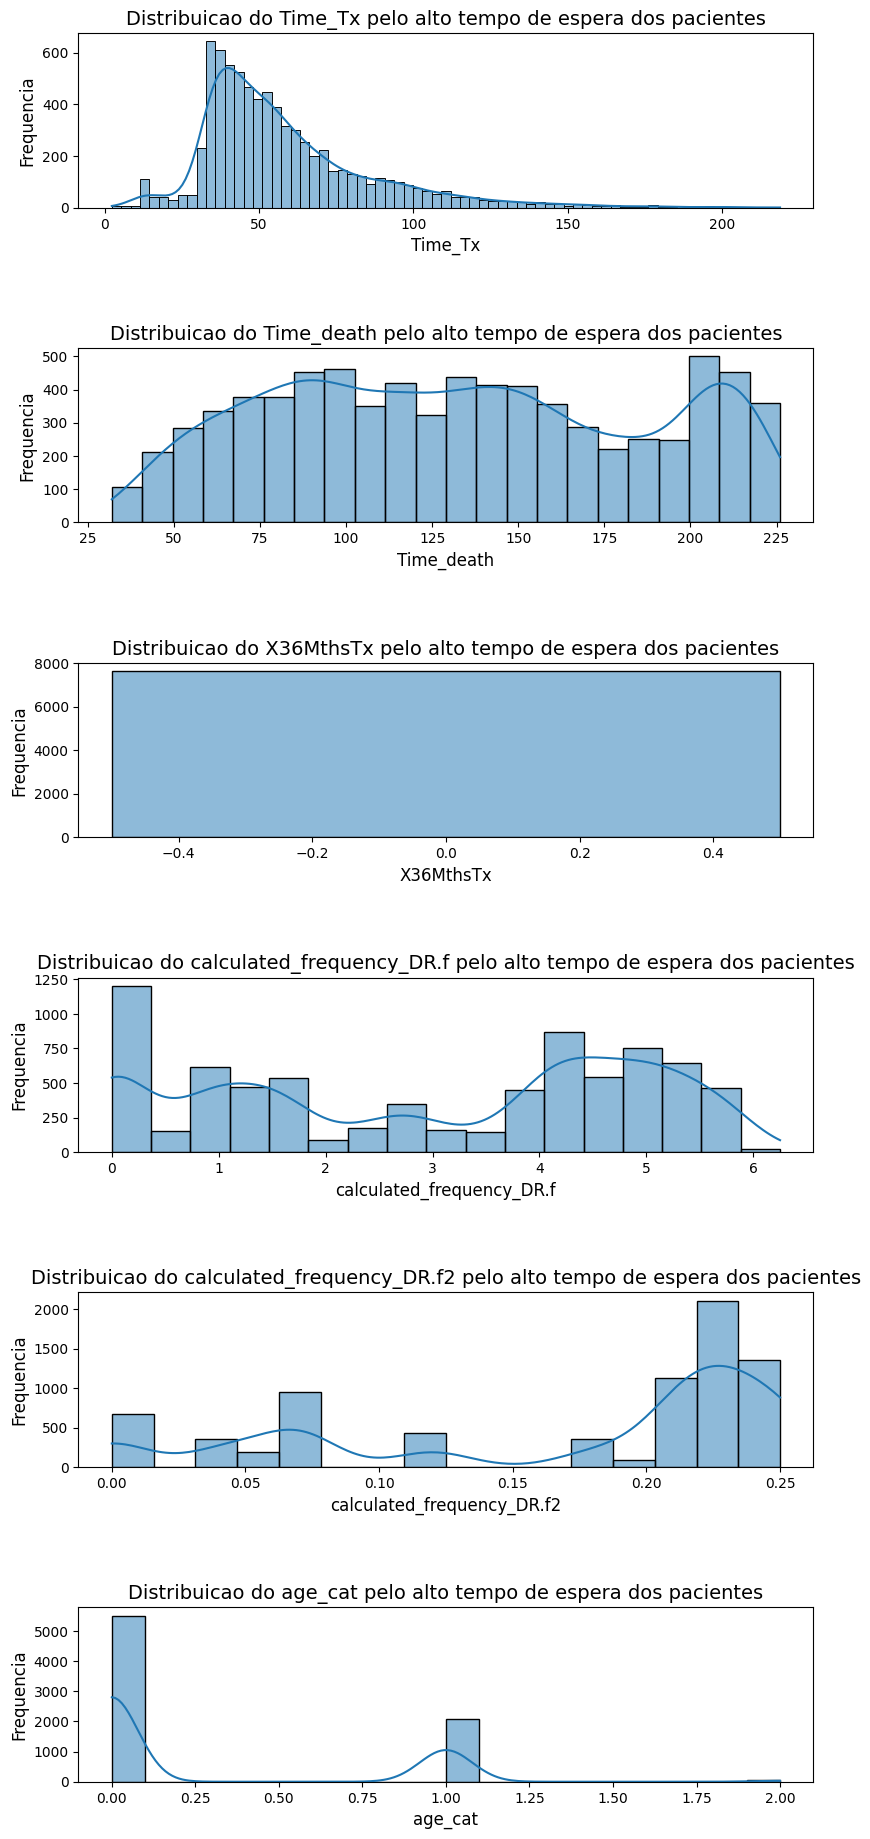

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# pacientes com tempo de espera acima da mediana
alto_tempo_de_espera_indices = y_selected[y_selected == 1].index

# tempo de espera acima da mediana
alto_tempo_de_espera_data = df.loc[alto_tempo_de_espera_indices, selected_features]

# distribuicao para cada variavel
fig, axes = plt.subplots(nrows=len(selected_features), ncols=1, figsize=(10, 20))
fig.tight_layout(pad=8.0)

for i, feature in enumerate(selected_features):
    sns.histplot(alto_tempo_de_espera_data[feature], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribuicao do {feature} pelo alto tempo de espera dos pacientes', fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel('Frequencia', fontsize=12)

plt.show()


time_tx: a maioria desses pacientes possui valores altos nesta variavel, indicando um padrao de tratamento prolongado antes do transplante.

time_death: a distribuicao mostra uma gama variada, com alguns picos, indicando periodos especificos em que os pacientes que esperam mais tempo tendem a falecer.

x36mthstx: ha uma concentracao de valores mais baixos, sugerindo que menos pacientes atingem um tratamento prolongado de 36 meses.

calculated_frequency_dr.f e calculated_frequency_dr.f2: estas variaveis relacionadas ao calculo de frequencias especificas mostram distribuicoes variadas, indicando diferentes padroes de caracteristicas geneticas.

C:\Users\Vemado\AppData\Local\Temp\ipykernel_20572\2764163330.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sorted_all_coeficientes, x='Absolute_Coefficient', y='Feature', palette='viridis')


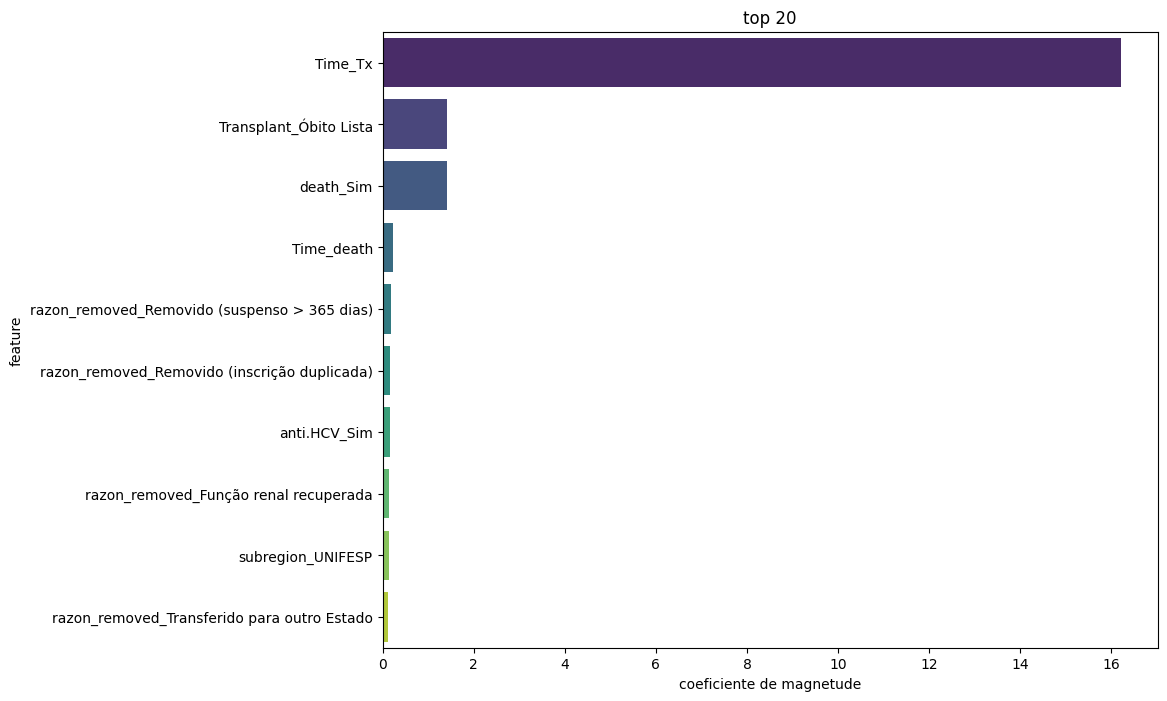

In [13]:
all_coeficientes = pd.DataFrame({
    'Feature': X_train_col.columns,
    'Coefficient': log_reg_enh.coef_[0]
})
all_coeficientes['Absolute_Coefficient'] = all_coeficientes['Coefficient'].abs()
sorted_all_coeficientes = all_coeficientes.sort_values(by='Absolute_Coefficient', ascending=False).head(10)


plt.figure(figsize=(10, 8))
sns.barplot(data=sorted_all_coeficientes, x='Absolute_Coefficient', y='Feature', palette='viridis')
plt.title('top 20')
plt.xlabel('coeficiente de magnetude')
plt.ylabel('feature')
plt.show()
